# Отток клиентов

## Описание проекта
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

**Цель исследования** - построить систему, способную спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

### Описание данных

Признаки:

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Целевой признак:

- `Exited ` — факт ухода клиента

## План исследования

- [1. Исследовательский анализ данных](#глава1)  
    - [1.1 Загрузка данных](#раздел1.1)  
    - [1.2 Информациях о клиентах](#раздел1.2)
    - [1.3 1.3 Предварительная обработка](#раздел1.3)
- [2. Выбор и обучение модели](#глава2)  
    - [2.1 Разделение исходных данных на обучающую, валидационную и тестовую выборки](#раздел2.1)  
    - [2.2 Модель решающего дерева без учета дисбаланса классов](#раздел2.2)  
    - [2.3 Масштабирование признаков](#раздел2.3)
    - [2.4 Балансирование классов](#раздел2.4)  
    - [2.5 Модель логистической регрессии](#раздел2.5)  
    - [2.6 Модель решающего дерева](#раздел2.6)  
    - [2.7 Модель случайного леса](#раздел2.7) 
    - [2.8 Проверка на тестовой выборке](#раздел2.8)
- [3. Вывод](#глава3)

<a id='глава1'></a>
# 1. Исследовательский анализ данных

<a id='раздел1.1'></a>
## 1.1 Загрузка данных

Выгрузим данные таблицы в следующий датафрейм:

data - Churn.csv

In [1]:
# Импорт необходимых библиотек
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pd.options.mode.chained_assignment = None

In [2]:
# Загрузка файла данных
data_path_local = 'C:/Users/Asus3/Documents/Яндекс.Практикум/projects/data/project_7/Churn.csv'
'''
#данные локально
data_path_local = 'C:/Users/ruleva_ad/Desktop/projects/data/project_7/Churn.csv'
data_path_local = 'C:/Users/Maroznik/Documents/dev/Яндекс.Практикум/projects/data/project_7/Churn.csv'
'''
#данные на сервере
data_path_server = '/datasets/Churn.csv'
    
if os.path.exists(data_path_local):
    data = pd.read_csv(data_path_local, sep=',')
    print('Успешное чтение файлов')
elif os.path.exists(data_path_server):
    data = pd.read_csv(data_path_server, sep=',')
else:
    print('Путь к файлу не найден')

Успешное чтение файлов


In [3]:
pd.set_option('display.max_columns', None)

<a id='раздел1.2'></a>
## 1.2 Информация о клиентах:

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Вывод

При первичном изучении датафрейма обнаружены следующие недостатки, которые необходимо устранить:
1. Записать названия столбцов по правилам змеиного регистра;
2. Избавиться от ненужных столбцов;
3. Избавиться от пропусков в столбцах;
4. Проверить на наличие дубликатов и удалить их, если они обнаружатся;
5. Найти возможные артефакты в столбцах и избавиться от них;
6. Преобразовать типы.

Целевой признак- `Exited`, категориальный.

<a id='раздел1.3'></a>
## 1.3 Предварительная обработка

In [6]:
# названия столбцов по правилам змеиного регистра
data = data.rename(columns= {'CustomerId': 'customer_id', 
                      'CreditScore': 'credit_score', 'NumOfProducts': 'num_of_products',
                      'HasCrCard': 'has_cr_card', 'IsActiveMember': 'is_active_member',
                      'EstimatedSalary': 'estimated_salary'})
data.columns = data.columns.str.lower()

In [7]:
# Избавиться от ненужных столбцов
data = data.drop(['rownumber', 'surname'], axis=1)

In [8]:
# Избавиться от пропусков в столбцах
data[data['tenure'].isna()]

,customer_id,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,15589475,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,15766205,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,15768193,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,15702298,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,15651280,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9944,15703923,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,15707861,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,15642785,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,15586914,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Данные пропуски не выглядят закономерными, и заполнить их какими-то адекватными значениями не представляется возможным. Они составляют 9.9% всех данных. Это не очень много, поэтому удалим эти значения:

In [9]:
data = data.dropna(subset=['tenure']).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       9091 non-null   int64  
 1   credit_score      9091 non-null   int64  
 2   geography         9091 non-null   object 
 3   gender            9091 non-null   object 
 4   age               9091 non-null   int64  
 5   tenure            9091 non-null   float64
 6   balance           9091 non-null   float64
 7   num_of_products   9091 non-null   int64  
 8   has_cr_card       9091 non-null   int64  
 9   is_active_member  9091 non-null   int64  
 10  estimated_salary  9091 non-null   float64
 11  exited            9091 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 852.4+ KB


In [10]:
# поиск дубликатов
str_columns = ['gender', 'geography']
for column in str_columns:
    data[column] = data[column].str.lower()
print('Количество дубликатов в таблице =', data.duplicated().sum())

Количество дубликатов в таблице = 0


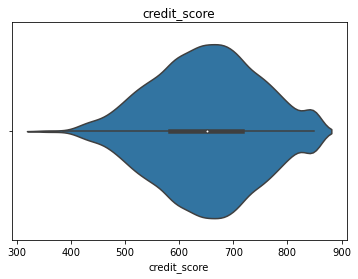

count    9091.000000
mean      650.736553
std        96.410471
min       350.000000
25%       584.000000
50%       652.000000
75%       717.000000
max       850.000000
Name: credit_score, dtype: float64


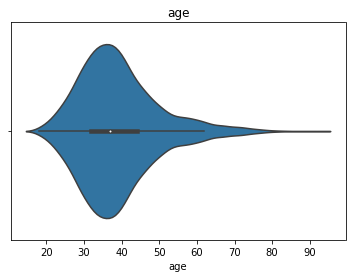

count    9091.000000
mean       38.949181
std        10.555581
min        18.000000
25%        32.000000
50%        37.000000
75%        44.000000
max        92.000000
Name: age, dtype: float64


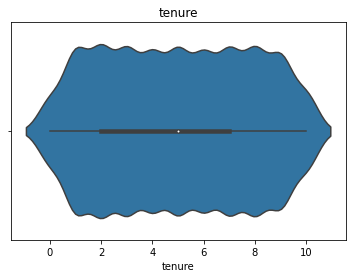

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64


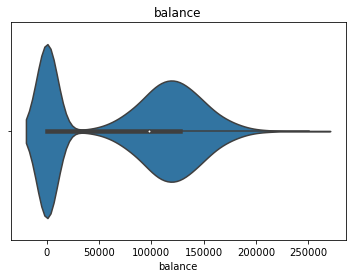

count      9091.000000
mean      76522.740015
std       62329.528576
min           0.000000
25%           0.000000
50%       97318.250000
75%      127561.890000
max      250898.090000
Name: balance, dtype: float64


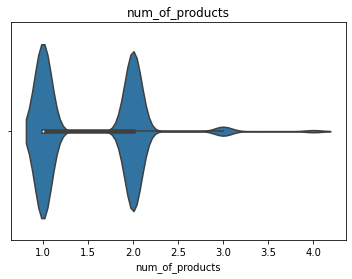

count    9091.000000
mean        1.530195
std         0.581003
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: num_of_products, dtype: float64


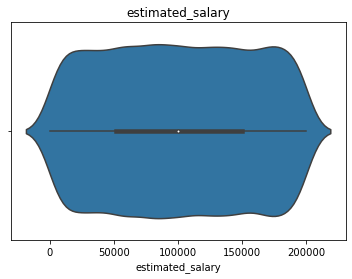

count      9091.000000
mean     100181.214924
std       57624.755647
min          11.580000
25%       51227.745000
50%      100240.200000
75%      149567.210000
max      199992.480000
Name: estimated_salary, dtype: float64


In [11]:
# поиск аномальных значений
str_columns = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
for column in str_columns:
    sns.violinplot(x=column, data=data)
    plt.title(column)
    plt.show()
    print(data[column].describe())

In [12]:
print('Множество значений в столбце "geography" :\n', data['geography'].unique())
print('Множество значений в столбце "gender" :\n', data['gender'].unique())
print('Множество значений в столбце "has_cr_card" :\n', data['has_cr_card'].unique())
print('Множество значений в столбце "is_active_member" :\n', data['is_active_member'].unique())
print('Множество значений в столбце "exited" :\n', data['exited'].unique())

Множество значений в столбце "geography" :
 ['france' 'spain' 'germany']
Множество значений в столбце "gender" :
 ['female' 'male']
Множество значений в столбце "has_cr_card" :
 [1 0]
Множество значений в столбце "is_active_member" :
 [1 0]
Множество значений в столбце "exited" :
 [1 0]


In [13]:
# преобразование типа
data = (data.astype({'customer_id': np.int32, 'credit_score': np.int32, 'tenure': np.int32, \
                     'age': np.int32, 'balance': np.float32, 'num_of_products': np.int32, \
                     'has_cr_card': np.int32, 'is_active_member': np.int32, 'estimated_salary': np.float32,\
                     'exited': np.int32}))
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       9091 non-null   int32  
 1   credit_score      9091 non-null   int32  
 2   geography         9091 non-null   object 
 3   gender            9091 non-null   object 
 4   age               9091 non-null   int32  
 5   tenure            9091 non-null   int32  
 6   balance           9091 non-null   float32
 7   num_of_products   9091 non-null   int32  
 8   has_cr_card       9091 non-null   int32  
 9   is_active_member  9091 non-null   int32  
 10  estimated_salary  9091 non-null   float32
 11  exited            9091 non-null   int32  
dtypes: float32(2), int32(8), object(2)
memory usage: 497.3+ KB


,customer_id,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,15634602,619,france,female,42,2,0.000000,1,1,1,101348.882812,1
1,15647311,608,spain,female,41,1,83807.859375,1,0,1,112542.578125,0
2,15619304,502,france,female,42,8,159660.796875,3,1,0,113931.570312,1
3,15701354,699,france,female,39,1,0.000000,2,0,0,93826.632812,0
4,15737888,850,spain,female,43,2,125510.820312,1,1,1,79084.101562,0


### Вывод

1. Записали названия столбцов по правилам змеиного регистра;
2. Избавились от ненужных столбцов;
3. Избавились от пропусков в столбцах удалением таких строк;
4. Дубликатов не обнаружено;
5. Артефактов не обнаружено;
6. Преобразовали тип данных.

count     9091
unique       2
top       male
freq      4974
Name: gender, dtype: object


Text(0.5, 1.0, 'Пол клиентов')

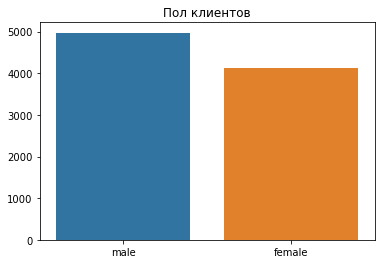

In [14]:
# Графическое представление некоторых данных
print(data['gender'].describe())
sns.barplot(
    x=['male', 'female'], 
    y=[data.query('gender == "male"').shape[0], 
       data.query('gender == "female"').shape[0]])
plt.title('Пол клиентов')

count       9091
unique         3
top       france
freq        4550
Name: geography, dtype: object


Text(0.5, 1.0, 'Страна проживания клиента')

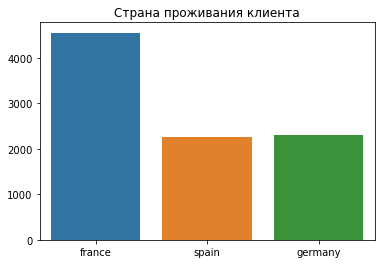

In [15]:
print(data['geography'].describe())
sns.barplot(
    x=['france', 'spain', 'germany'], 
    y=[data.query('geography == "france"').shape[0], 
       data.query('geography == "spain"').shape[0],
       data.query('geography == "germany"').shape[0]])
plt.title('Страна проживания клиента')

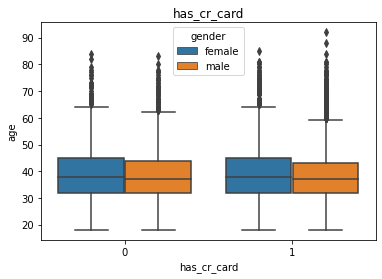

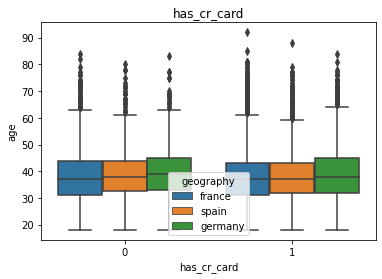

count    9091.000000
mean        0.704983
std         0.456076
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: has_cr_card, dtype: float64


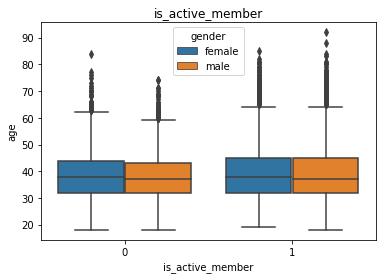

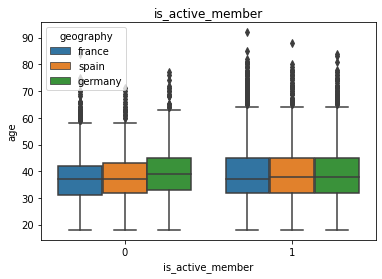

count    9091.000000
mean        0.515565
std         0.499785
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: is_active_member, dtype: float64


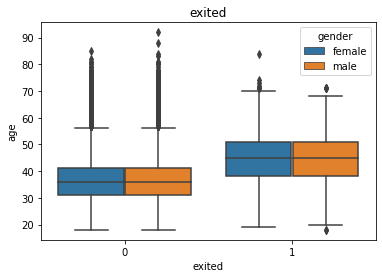

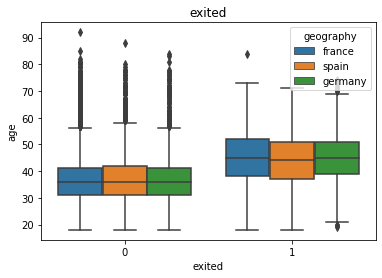

count    9091.000000
mean        0.203938
std         0.402946
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: exited, dtype: float64


In [16]:
str_columns = ['has_cr_card', 'is_active_member', 'exited']
for column in str_columns:
    sns.boxplot(x=column, y='age', hue='gender', data=data)
    plt.title(column)
    plt.show()    
    plt.title(column)
    sns.boxplot(x=column, y='age', hue='geography', data=data)
    plt.show()
    print(data[column].describe())

На основании предобработки и исследования данных можно сделать следующие выводы:
1. Кредитный рейтинг у большинства клиентов имеет хорошие показатели, хоть небольшая часть и является ненадежными.
2. Медианный возраст - 37 лет. В основном колеблется от 18 до 62 лет, но есть и небольшое число более возрастных клиетнов, вплоть до 92 лет.
3. Время, в течение которого клиент является клиентом банка лежит в интервале от 0 до 10 лет, основная часть - от 2 до 7, а медианное значение - 5 лет.
4. Баланс основной массы клиентов - до 130000. Медианное значение - 97000. Все клиенты, укладываются в значения до 251000.
5. Клиенты в основном являются владельцами одного-двух продуктов, иногда трёх, крайне редко четырех.
6. Медианная ожидаемая зарплата равна 100000.
7. Мужчин примерно на 20% больше, чем женщин.
8. Наибольшее число клиентов во Франции- примерно 4550, в Испании и Германии поровну и примерно вдвое меньше, чем во Франции в каждой.
9. Существенных различий по показателям владения кредитной картой, активности и ухода клиентов в зависимости от пола или страны не наблюдается.

<a id='глава2'></a>
# 2. Выбор и обучение модели

<a id='раздел2.1'></a>
## 2.1 Разделение исходных данных на обучающую, валидационную и тестовую выборки.

Разделение производим в пропорции 3:1:1.

In [17]:
data_ohe = data 
data_ohe = pd.get_dummies(data_ohe, drop_first=True) #ohe
display(data_ohe)
data_train, data_all_valid = train_test_split(data_ohe, test_size=0.4, random_state=12345, stratify=data_ohe['exited'])
features_train = data_train.drop(['exited'], axis=1)
target_train = data_train['exited']
data_valid, data_test = train_test_split(data_all_valid, test_size=0.5, random_state=12345, stratify=data_all_valid['exited'])
features_valid = data_valid.drop(['exited'], axis=1)
target_valid = data_valid['exited']
features_test = data_test.drop(['exited'], axis=1)
target_test = data_test['exited']

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,15634602,619,42,2,0.000000,1,1,1,101348.882812,1,0,0,0
1,15647311,608,41,1,83807.859375,1,0,1,112542.578125,0,0,1,0
2,15619304,502,42,8,159660.796875,3,1,0,113931.570312,1,0,0,0
3,15701354,699,39,1,0.000000,2,0,0,93826.632812,0,0,0,0
4,15737888,850,43,2,125510.820312,1,1,1,79084.101562,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9086,15719294,800,29,2,0.000000,2,0,0,167773.546875,0,0,0,0
9087,15606229,771,39,5,0.000000,2,1,0,96270.640625,0,0,0,1
9088,15569892,516,35,10,57369.609375,1,1,1,101699.773438,0,0,0,1
9089,15584532,709,36,7,0.000000,1,0,1,42085.578125,1,0,0,0


**Вывод**

Разделение произведено успешно.

<a id='раздел2.2'></a>
## 2.2 Модель решающего дерева без учета дисбаланса классов

In [18]:
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

In [19]:
print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(4342, 12)
(1112, 12)
(4342,)
(1112,)


Положительного класса почти в 4 раза меньше, чем отрицательного. Дисбаланс классов имеет место. Для сравнения в качестве примера обучим одну модель - решающего дерева.

In [20]:
best_decision_tree_model = None
best_decision_tree_result = 0
best_decision_tree_depth = 0
for depth in range(1, 6):
    decision_tree_model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    decision_tree_model.fit(features_train, target_train)
    predictions = decision_tree_model.predict(features_valid) 
    result =  f1_score(target_valid, predictions)
    if result > best_decision_tree_result:
        best_decision_tree_model = decision_tree_model
        best_decision_tree_result = result  
        best_decision_tree_depth = depth
        
print("F1 лучшей модели:", best_decision_tree_result, "\nDepth лучшей модели:", best_decision_tree_depth)

F1 лучшей модели: 0.5733788395904437 
Depth лучшей модели: 5


Напишим функцию для построения кривой ошибок (ROC-кривая):

In [21]:
def roc(model, features, target):
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    plt.figure()
    plt.plot(fpr, tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.grid(True)
    plt.show()
    auc_roc = roc_auc_score(target, probabilities_one_valid)
    print(f'AUC-ROC = {auc_roc}')

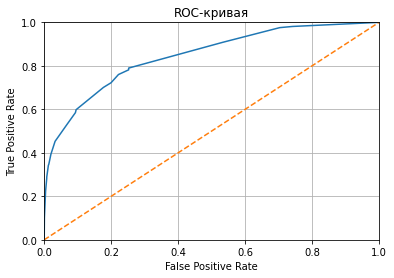

AUC-ROC = 0.8450702913547316


In [22]:
roc(model=best_decision_tree_model, features=features_valid, target=target_valid)

Значение F1- метрики низкое. AUC-ROC больше, чем у случайной модели, значит модель адекватна. Необходимо улучшать качество модели.

<a id='раздел2.3'></a>
## 2.3 Масштабирование признаков

Признаки имеют разный масштаб. Приведем их к одному.

In [23]:
numeric = ['credit_score', 'age', 'tenure', 'balance']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head()

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
8837,15612832,-1.292898,-0.660843,0.686341,0.786635,1,0,0,86786.406250,0,0,1
1090,15628298,-1.563714,0.778434,1.034232,0.833795,1,1,0,179227.125000,0,1,0
7609,15567147,1.581914,0.106771,-0.357331,-1.222967,2,1,1,81908.093750,0,1,1
7279,15644295,0.842379,0.010820,-1.053112,0.807063,1,1,1,74850.929688,0,1,0
2245,15764174,-0.397123,-1.236554,-0.357331,-1.222967,2,1,1,179780.734375,0,1,0


Масштабирование выполнено успешно.

<a id='раздел2.4'></a>
## 2.4 Балансирование классов

Балансировку можно проводить следующими способами: взвешиванием классов, увеличением выборки, уменьшением выборки. Чтобы не потерять классы для обучения не будем использовать уменьшение выборки, а из оставшихся вариантов выберем один. 

Произведем увеличение выборки.

In [24]:
def upsample(features, target, repeat):
    features_zeros = features[target_train == 0]
    features_ones = features[target_train == 1]
    target_zeros = target[target_train == 0]
    target_ones = target[target_train == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    return features_upsampled, target_upsampled

In [25]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)


In [26]:
features_zeros = features_upsampled[target_upsampled == 0]
features_ones = features_upsampled[target_upsampled == 1]
target_zeros = target_upsampled[target_upsampled == 0]
target_ones = target_upsampled[target_upsampled == 1]

In [27]:
print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(4342, 12)
(4448, 12)
(4342,)
(4448,)


Балансирование проведено успешно

<a id='раздел2.5'></a>
## 2.5 Модель логистической регрессии

Обучим модель с выбором оптимального порога

In [28]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_upsampled, target_upsampled)
probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [29]:
for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    print('Порог = {:.2f} | F1 = {:.3f}'.format(threshold, f1))

Порог = 0.00 | F1 = 0.339
Порог = 0.02 | F1 = 0.339
Порог = 0.04 | F1 = 0.339
Порог = 0.06 | F1 = 0.339
Порог = 0.08 | F1 = 0.339
Порог = 0.10 | F1 = 0.339
Порог = 0.12 | F1 = 0.339
Порог = 0.14 | F1 = 0.339
Порог = 0.16 | F1 = 0.339
Порог = 0.18 | F1 = 0.339
Порог = 0.20 | F1 = 0.339
Порог = 0.22 | F1 = 0.339
Порог = 0.24 | F1 = 0.339
Порог = 0.26 | F1 = 0.339
Порог = 0.28 | F1 = 0.339
Порог = 0.30 | F1 = 0.339
Порог = 0.32 | F1 = 0.339
Порог = 0.34 | F1 = 0.339
Порог = 0.36 | F1 = 0.339
Порог = 0.38 | F1 = 0.339
Порог = 0.40 | F1 = 0.339
Порог = 0.42 | F1 = 0.339
Порог = 0.44 | F1 = 0.339
Порог = 0.46 | F1 = 0.339
Порог = 0.48 | F1 = 0.339
Порог = 0.50 | F1 = 0.331
Порог = 0.52 | F1 = 0.000
Порог = 0.54 | F1 = 0.000
Порог = 0.56 | F1 = 0.000
Порог = 0.58 | F1 = 0.000
Порог = 0.60 | F1 = 0.000
Порог = 0.62 | F1 = 0.000
Порог = 0.64 | F1 = 0.000
Порог = 0.66 | F1 = 0.000
Порог = 0.68 | F1 = 0.000
Порог = 0.70 | F1 = 0.000
Порог = 0.72 | F1 = 0.000
Порог = 0.74 | F1 = 0.000
Порог = 0.76

In [30]:
best_lr_model = None
best_lr_result = 0
best_lr_iter = 0
for i in range(100, 1000, 100):
    lr_model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=i)
    lr_model.fit(features_upsampled, target_upsampled)
    predictions = lr_model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    if result > best_lr_result:
        best_lr_model = lr_model
        best_lr_result = result
        best_lr_iter = i

print("F1 наилучшей модели на валидационной выборке:", best_lr_result, "\nIter лучшей модели:", best_lr_iter)

F1 наилучшей модели на валидационной выборке: 0.33896756509821835 
Iter лучшей модели: 100


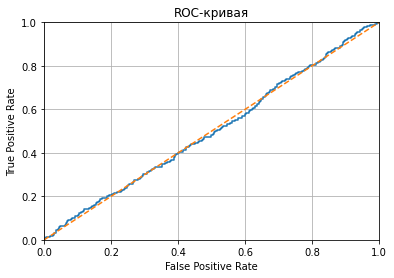

AUC-ROC = 0.5007274088783001


In [31]:
roc(model=best_lr_model, features=features_valid, target=target_valid)

Модель логистической регрессии плохо проявляет себя, даже с учетом баланса классов. ROC-кривая практически полностью совпадает со случайной моделью.

<a id='раздел2.6'></a>
## 2.6 Модель решающего дерева

Обучим модель с выбором оптимальной глубины

In [32]:
best_dt_model = None
best_dt_result = 0
best_dt_depth = 0
for depth in range(1, 21):
    dt_model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    dt_model.fit(features_upsampled, target_upsampled)
    predictions = dt_model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    if result > best_dt_result:
        best_dt_model = dt_model
        best_dt_result = result  
        best_dt_depth = depth
        
print("F1 лучшей модели:", best_dt_result, "\nDepth лучшей модели:", best_dt_depth)    

F1 лучшей модели: 0.584493041749503 
Depth лучшей модели: 6


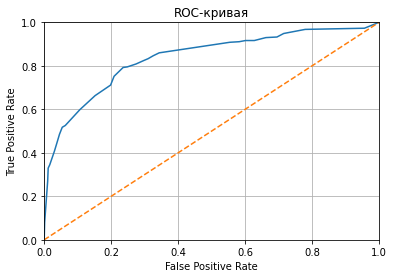

AUC-ROC = 0.8375782593226622


In [33]:
roc(model=best_dt_model, features=features_valid, target=target_valid)

Модель решающего дерева проявляет себя лучше модели логистической регрессии. Баланс классов также немного улучшил F1-метрику. ROC-кривая и значение AUC-ROC значительно лучше по сравнению с предыдущими моделями.

<a id='раздел2.7'></a>
## 2.7 Модель случайного леса

Обучим модель случайного леса в два этапа: сначала найдем оптимальную глубину на небольшом числе деревьев, а затем выберем численность при найденной оптимальной глубине.

In [34]:
%%time
best_rf_model = None
best_rf_result = 0
best_rf_est = 0
best_rf_depth = 0
for depth in range(1, 21, 1):
    rf_model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=12345)
    rf_model.fit(features_upsampled, target_upsampled)
    prediction_valid = rf_model.predict(features_valid)
    result = f1_score(target_valid, prediction_valid)
    if result > best_rf_result:
        best_rf_model = rf_model
        best_rf_result = result
        best_rf_depth = depth
print("F1 наилучшей модели:", best_rf_result, "\nDepth лучшей модели:", best_rf_depth)

F1 наилучшей модели: 0.6415094339622641 
Depth лучшей модели: 13
Wall time: 2.62 s


In [35]:
%%time
for est in range(20, 60, 1):
    rf_model = RandomForestClassifier(n_estimators=est, max_depth=best_rf_depth, random_state=12345)
    rf_model.fit(features_upsampled, target_upsampled)
    prediction_valid = rf_model.predict(features_valid)
    result = f1_score(target_valid, prediction_valid)
    if result > best_rf_result:
        best_rf_model = rf_model
        best_rf_result = result
        best_rf_est = est
print("F1 наилучшей модели:", best_rf_result, "\nEst лучшей модели:", best_rf_est)

F1 наилучшей модели: 0.6566757493188011 
Est лучшей модели: 28
Wall time: 12.9 s


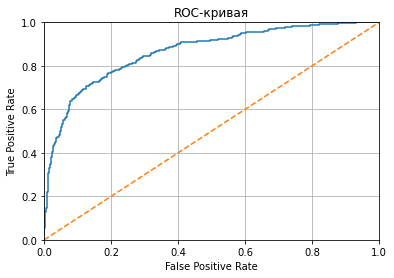

AUC-ROC = 0.865489897305886


In [36]:
roc(model=best_rf_model, features=features_valid, target=target_valid)

Модель случайного леса проявляет себя лучше модели решающего древа. Требуемое минимальное значение F1-метрики получилось превзойти. AUC-ROC приблизительно равно 1- практически идеальный результат.

<a id='раздел2.8'></a>
## 2.8 Проверка на тестовой выборке

In [37]:
%%time
predictions = best_rf_model.predict(features_test)
result = f1_score(target_test, predictions)
print("F1 наилучшей модели решающего дерева на тестовой выборке:",
      result, "\nDepth лучшей модели:", best_rf_depth,
      "\nEst лучшей модели:", best_rf_est)

F1 наилучшей модели решающего дерева на тестовой выборке: 0.6046511627906977 
Depth лучшей модели: 13 
Est лучшей модели: 28
Wall time: 20 ms


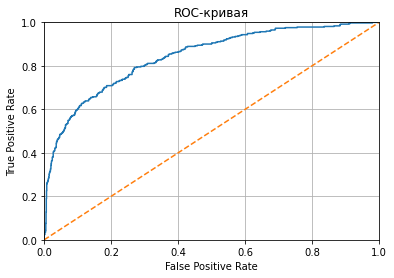

AUC-ROC = 0.8421263272326548


In [38]:
roc(model=best_rf_model, features=features_test, target=target_test)

<a id='глава3'></a>
# 3. Вывод 

Результаты на тестовой выборке в целом соотносятся с результатами на валидационной выборке, хоть F1 и немного хуже. Требуемое значение F1-метрики подтверждено. Значение AUC-ROC лучшей модели случайного леса снизилось до 0.84, что значительно хуже результатов на валидационной выборке, но на F1-метрике это не сильно сказалось.